<a href="https://colab.research.google.com/drive/1Yh-M4nmlcsqjBGTVXxQErR5LF42KzdqH" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Auto-Encoder(CAE)

## 1. Load dataset

## 2. Import python libraries and define util functions

In [2]:
''' import '''
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

from utils import get_device, get_data_model_path, set_seed, img_read, img_read_plot, plot_loss

In [3]:
''' set '''
device = get_device()
data_path, model_path = get_data_model_path(os.getcwd())
set_seed(0)

device, data_path, model_path

(device(type='cuda'),
 'd:\\workspace\\study\\DL2\\dataset',
 'd:\\workspace\\study\\DL2\\model')

## 3. Check dataset

## 4. Convert images into trainable data

In [4]:
''' load data '''
src = os.path.join(data_path, 'data_3000')
files = os.listdir(src)


X,Y = [],[]

for file in files:
    X.append(img_read(src, file) / 255.0)   # normalize
    Y.append(float(file[:-4]))              # label -> file name

X = np.array(X)
Y = np.array(Y)

print('X.shape:', X.shape)
print('Y.shape:', Y.shape)

X.shape: (3000, 56, 56)
Y.shape: (3000,)


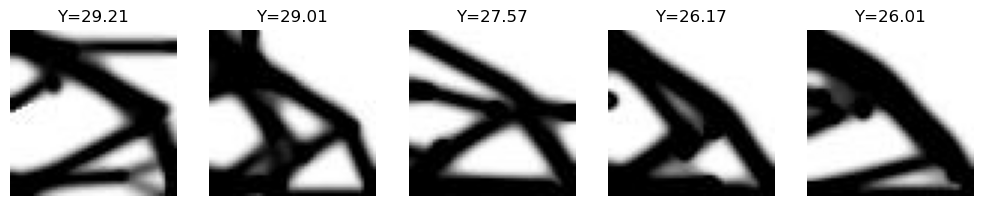

In [5]:
# check images
nplot = 5
idx = np.random.randint(1, 3000, nplot)

fig = plt.figure(figsize=(15,5))

for i in range(nplot):
    ax = fig.add_subplot(1, nplot+1, i+1)
    ax.imshow(X[idx[i],:,:], cmap='gray')
    ax.set_title(f"Y={Y[idx[i]]:.2f}")
    ax.axis('off')
plt.show()

In [6]:
''' train test split '''
X_tr, X_ts, Y_tr, Y_ts = train_test_split(X,Y, test_size=0.2, random_state=1, shuffle=True)

print(X_tr.shape, X_ts.shape, Y_tr.shape,Y_ts.shape)


# # reshape (flatten) -> x conv
# X_tr = X_tr.reshape(-1, np.prod(X_tr.shape[1:])) # (2400, 56, 56) -> (2400, 56*56)
# X_ts = X_ts.reshape(-1, np.prod(X_ts.shape[1:]))

# print(X_tr.shape,X_ts.shape)


# convert to Tensor
X_tr = torch.tensor(X_tr, dtype=torch.float32).to(device)
Y_tr = torch.tensor(Y_tr, dtype=torch.float32)
X_ts = torch.tensor(X_ts, dtype=torch.float32).to(device).unsqueeze(1)
Y_ts = torch.tensor(Y_ts, dtype=torch.float32)

(2400, 56, 56) (600, 56, 56) (2400,) (600,)


## 5. Set to model architecture

In [26]:
''' model '''
class ConvAutoencoder(nn.Module):
    def __init__(self, enc_chs, dec_chs=None):
        super(ConvAutoencoder, self).__init__()

        if dec_chs is None:
            dec_chs = enc_chs[::-1]

        # encoder
        self.encoder = nn.ModuleList()
        in_ch = enc_chs[0] # grayscale
    
        for i in range(len(enc_chs)-2): # relu o
            out_ch = enc_chs[i+1]
            self.encoder.append(nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=2, padding=1))
            self.encoder.append(nn.ReLU())
            in_ch = out_ch

        out_ch = enc_chs[-1] # relu x
        self.encoder.append(nn.Conv2d(in_ch, out_ch, kernel_size=4, stride=2, padding=1))

        # decoder
        self.decoder = nn.ModuleList()
        in_ch = out_ch # dec_chs[0]

        for i in range(len(dec_chs)-2): # relu o
            out_ch = dec_chs[i+1]
            self.decoder.append(nn.ConvTranspose2d(in_ch, out_ch, kernel_size=3, stride=2, padding=1, output_padding=1))
            self.decoder.append(nn.ReLU())
            in_ch = out_ch

        out_ch = dec_chs[-1] # relu x
        self.decoder.append(nn.ConvTranspose2d(in_ch, out_ch, kernel_size=3, stride=2, padding=1, output_padding=1))

    def forward(self, x):
        for conv in self.encoder:
            x = conv(x)
        for conv_T in self.decoder:
            x = conv_T(x)
        return x

In [27]:
# ''' model '''
# class ConvAutoencoder(nn.Module):
#     def __init__(self):
#         super(ConvAutoencoder, self).__init__()

#         self.encoder = nn.Sequential(
#             nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
#         )

#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1)
#         )
        
#     def forward(self, x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
#         return decoded

## 6. Set model hyperparameters

In [ ]:
cae = ConvAutoencoder(enc_chs=[1, 64, 128, 256], dec_chs=[256, 128, 64, 1]).to(device)

summary(cae, (1, 56, 56))  # input shape: (channels, height, width)
cae

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
              ReLU-2           [-1, 64, 28, 28]               0
            Conv2d-3          [-1, 128, 14, 14]          73,856
              ReLU-4          [-1, 128, 14, 14]               0
            Conv2d-5            [-1, 256, 7, 7]         524,544
   ConvTranspose2d-6          [-1, 128, 14, 14]         295,040
              ReLU-7          [-1, 128, 14, 14]               0
   ConvTranspose2d-8           [-1, 64, 28, 28]          73,792
              ReLU-9           [-1, 64, 28, 28]               0
  ConvTranspose2d-10            [-1, 1, 56, 56]             577
Total params: 968,449
Trainable params: 968,449
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 2.42
Params size (MB): 3.69
Estimated T

ConvAutoencoder(
  (encoder): ModuleList(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (decoder): ModuleList(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [ ]:
''' hyper params '''
num_epochs = 200
batch_size = 64
learning_rate = 1e-3

''' loss, optim '''
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(params=cae.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=100, gamma=0.8)

In [23]:
''' dataloader '''
train_dataset = TensorDataset(X_tr, X_tr)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

## 7. Train model

Epoch [ 1/300], Train loss: 0.001251


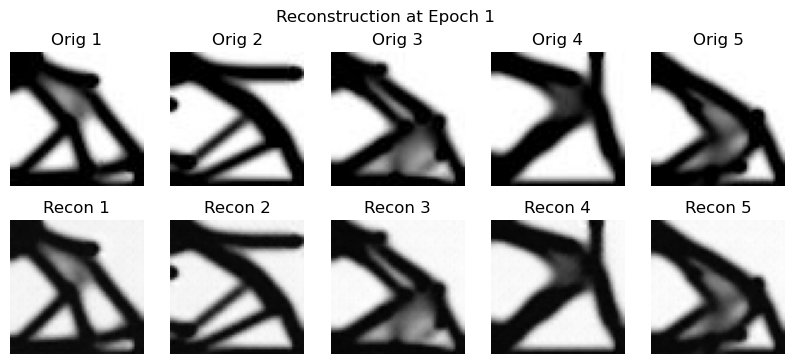

Epoch [ 2/300], Train loss: 0.000172
Epoch [ 3/300], Train loss: 0.000107
Epoch [ 4/300], Train loss: 0.000082
Epoch [ 5/300], Train loss: 0.000069
Epoch [ 6/300], Train loss: 0.000061
Epoch [ 7/300], Train loss: 0.000056
Epoch [ 8/300], Train loss: 0.000050
Epoch [ 9/300], Train loss: 0.000048
Epoch [10/300], Train loss: 0.000046
Epoch [11/300], Train loss: 0.000041
Epoch [12/300], Train loss: 0.000044
Epoch [13/300], Train loss: 0.000045
Epoch [14/300], Train loss: 0.000036
Epoch [15/300], Train loss: 0.000038
Epoch [16/300], Train loss: 0.000037
Epoch [17/300], Train loss: 0.000033
Epoch [18/300], Train loss: 0.000057
Epoch [19/300], Train loss: 0.000029
Epoch [20/300], Train loss: 0.000030
Epoch [21/300], Train loss: 0.000032
Epoch [22/300], Train loss: 0.000035
Epoch [23/300], Train loss: 0.000028
Epoch [24/300], Train loss: 0.000062
Epoch [25/300], Train loss: 0.000027
Epoch [26/300], Train loss: 0.000031
Epoch [27/300], Train loss: 0.000029
Epoch [28/300], Train loss: 0.000036
E

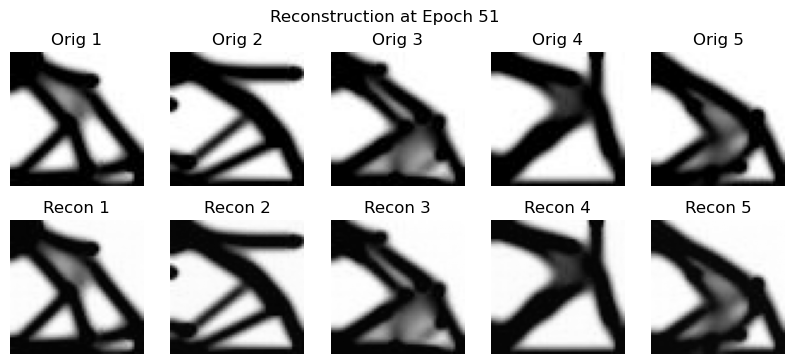

Epoch [52/300], Train loss: 0.000029
Epoch [53/300], Train loss: 0.000040
Epoch [54/300], Train loss: 0.000032
Epoch [55/300], Train loss: 0.000031
Epoch [56/300], Train loss: 0.000040
Epoch [57/300], Train loss: 0.000035
Epoch [58/300], Train loss: 0.000030
Epoch [59/300], Train loss: 0.000037
Epoch [60/300], Train loss: 0.000028
Epoch [61/300], Train loss: 0.000029
Epoch [62/300], Train loss: 0.000035
Epoch [63/300], Train loss: 0.000028
Epoch [64/300], Train loss: 0.000035
Epoch [65/300], Train loss: 0.000030
Epoch [66/300], Train loss: 0.000026
Epoch [67/300], Train loss: 0.000046
Epoch [68/300], Train loss: 0.000031
Epoch [69/300], Train loss: 0.000025
Epoch [70/300], Train loss: 0.000046
Epoch [71/300], Train loss: 0.000027
Epoch [72/300], Train loss: 0.000035
Epoch [73/300], Train loss: 0.000032
Epoch [74/300], Train loss: 0.000026
Epoch [75/300], Train loss: 0.000041
Epoch [76/300], Train loss: 0.000031
Epoch [77/300], Train loss: 0.000028
Epoch [78/300], Train loss: 0.000047
E

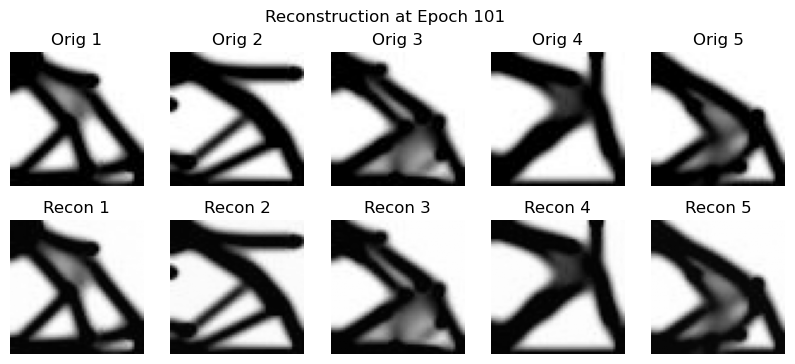

Epoch [102/300], Train loss: 0.000017
Epoch [103/300], Train loss: 0.000017
Epoch [104/300], Train loss: 0.000018
Epoch [105/300], Train loss: 0.000018
Epoch [106/300], Train loss: 0.000019
Epoch [107/300], Train loss: 0.000019
Epoch [108/300], Train loss: 0.000020
Epoch [109/300], Train loss: 0.000021
Epoch [110/300], Train loss: 0.000020
Epoch [111/300], Train loss: 0.000022
Epoch [112/300], Train loss: 0.000025
Epoch [113/300], Train loss: 0.000022
Epoch [114/300], Train loss: 0.000035
Epoch [115/300], Train loss: 0.000023
Epoch [116/300], Train loss: 0.000022
Epoch [117/300], Train loss: 0.000033
Epoch [118/300], Train loss: 0.000022
Epoch [119/300], Train loss: 0.000024
Epoch [120/300], Train loss: 0.000021
Epoch [121/300], Train loss: 0.000025
Epoch [122/300], Train loss: 0.000029
Epoch [123/300], Train loss: 0.000026
Epoch [124/300], Train loss: 0.000026
Epoch [125/300], Train loss: 0.000028
Epoch [126/300], Train loss: 0.000025
Epoch [127/300], Train loss: 0.000021
Epoch [128/3

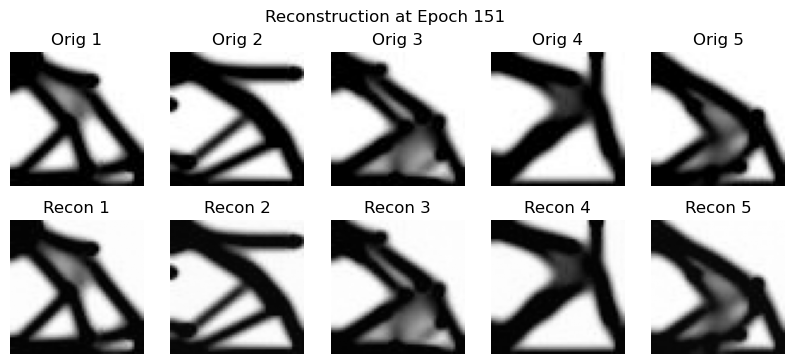

Epoch [152/300], Train loss: 0.000023
Epoch [153/300], Train loss: 0.000021
Epoch [154/300], Train loss: 0.000026
Epoch [155/300], Train loss: 0.000032
Epoch [156/300], Train loss: 0.000020
Epoch [157/300], Train loss: 0.000025
Epoch [158/300], Train loss: 0.000048
Epoch [159/300], Train loss: 0.000032
Epoch [160/300], Train loss: 0.000018
Epoch [161/300], Train loss: 0.000020
Epoch [162/300], Train loss: 0.000022
Epoch [163/300], Train loss: 0.000019
Epoch [164/300], Train loss: 0.000025
Epoch [165/300], Train loss: 0.000031
Epoch [166/300], Train loss: 0.000020
Epoch [167/300], Train loss: 0.000022
Epoch [168/300], Train loss: 0.000020
Epoch [169/300], Train loss: 0.000024
Epoch [170/300], Train loss: 0.000025
Epoch [171/300], Train loss: 0.000024
Epoch [172/300], Train loss: 0.000024
Epoch [173/300], Train loss: 0.000022
Epoch [174/300], Train loss: 0.000023
Epoch [175/300], Train loss: 0.000021
Epoch [176/300], Train loss: 0.000028
Epoch [177/300], Train loss: 0.000025
Epoch [178/3

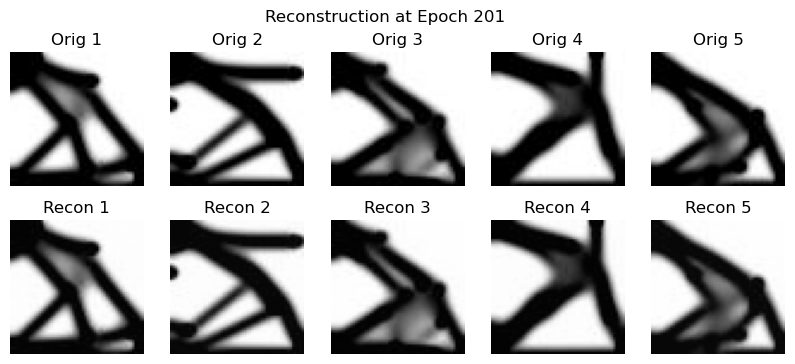

Epoch [202/300], Train loss: 0.000013
Epoch [203/300], Train loss: 0.000013
Epoch [204/300], Train loss: 0.000013
Epoch [205/300], Train loss: 0.000013
Epoch [206/300], Train loss: 0.000013
Epoch [207/300], Train loss: 0.000015
Epoch [208/300], Train loss: 0.000014
Epoch [209/300], Train loss: 0.000015
Epoch [210/300], Train loss: 0.000015
Epoch [211/300], Train loss: 0.000015
Epoch [212/300], Train loss: 0.000016
Epoch [213/300], Train loss: 0.000018
Epoch [214/300], Train loss: 0.000021
Epoch [215/300], Train loss: 0.000016
Epoch [216/300], Train loss: 0.000017
Epoch [217/300], Train loss: 0.000016
Epoch [218/300], Train loss: 0.000016
Epoch [219/300], Train loss: 0.000019
Epoch [220/300], Train loss: 0.000018
Epoch [221/300], Train loss: 0.000021
Epoch [222/300], Train loss: 0.000017
Epoch [223/300], Train loss: 0.000017
Epoch [224/300], Train loss: 0.000019
Epoch [225/300], Train loss: 0.000016
Epoch [226/300], Train loss: 0.000021
Epoch [227/300], Train loss: 0.000015
Epoch [228/3

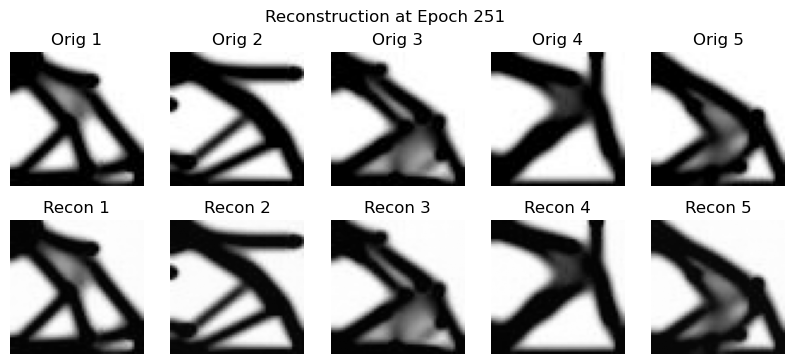

Epoch [252/300], Train loss: 0.000016
Epoch [253/300], Train loss: 0.000016
Epoch [254/300], Train loss: 0.000022
Epoch [255/300], Train loss: 0.000015
Epoch [256/300], Train loss: 0.000016
Epoch [257/300], Train loss: 0.000016
Epoch [258/300], Train loss: 0.000017
Epoch [259/300], Train loss: 0.000017
Epoch [260/300], Train loss: 0.000017
Epoch [261/300], Train loss: 0.000020
Epoch [262/300], Train loss: 0.000022
Epoch [263/300], Train loss: 0.000016
Epoch [264/300], Train loss: 0.000015
Epoch [265/300], Train loss: 0.000013
Epoch [266/300], Train loss: 0.000044
Epoch [267/300], Train loss: 0.000013
Epoch [268/300], Train loss: 0.000013
Epoch [269/300], Train loss: 0.000015
Epoch [270/300], Train loss: 0.000014
Epoch [271/300], Train loss: 0.000017
Epoch [272/300], Train loss: 0.000013
Epoch [273/300], Train loss: 0.000021
Epoch [274/300], Train loss: 0.000014
Epoch [275/300], Train loss: 0.000015
Epoch [276/300], Train loss: 0.000017
Epoch [277/300], Train loss: 0.000018
Epoch [278/3

In [24]:
''' train '''
loss_tr_hist = []

for epoch in range(num_epochs):
    
    # training
    cae.train()
    total_loss = 0.0

    for x, _ in train_loader:
        optimizer.zero_grad()
        x = x.unsqueeze(1)
        output = cae(x)
        loss = criterion(output, x)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)

    # history
    loss_tr_hist.append(avg_loss)
    print(f"Epoch [{epoch+1:2}/{num_epochs}], Train loss: {avg_loss:.6f}")

    scheduler.step()
    

    # validation
    if epoch % 50 == 0:
        cae.eval()
        with torch.no_grad():
            n = 5  # num of img

            plt.figure(figsize=(10, 4))
            
            for i in range(n):

                orig_img = X_ts.cpu()[i].reshape(56,56)
                recon_img = cae(X_ts[i]).detach().cpu().reshape(56,56)      # detach() : grad 연산 그래프에서 분리,     cpu() : gpu->cpu 복사

                # original
                ax = plt.subplot(2, n, i+1)
                plt.imshow(orig_img, cmap="gray")
                plt.title(f"Orig {i+1}")
                ax.axis('off')

                # recon
                ax = plt.subplot(2, n, i+1+n)
                plt.imshow(recon_img, cmap="gray")
                plt.title(f"Recon {i+1}")
                ax.axis('off')

            plt.suptitle(f"Reconstruction at Epoch {epoch+1}")
            plt.show()
            cae.train()

# save model
torch.save(cae.state_dict(), os.path.join(model_path, 'CAE_model.pth'))

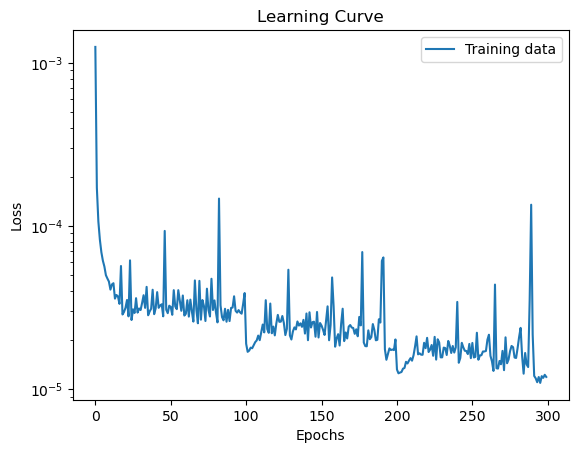

In [25]:
# graph visualization
plot_loss(loss_tr_hist, logy=True, title='Learning Curve')
plt.show()

## 8. Load & Evaluate model

- Compare the orginial image and the reconstructed image

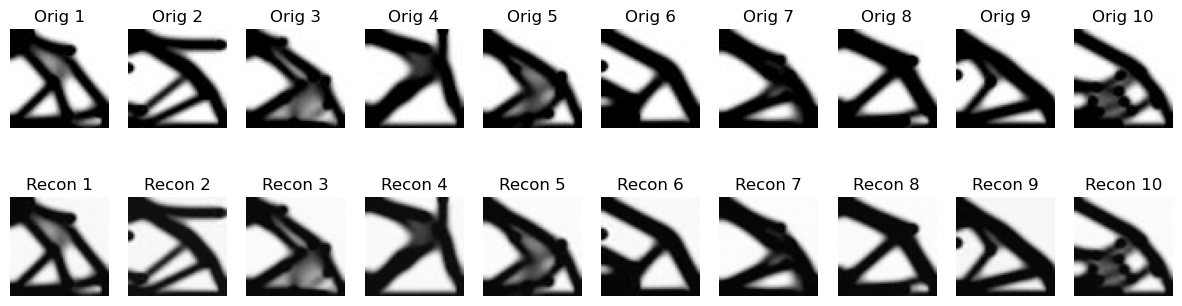

In [ ]:
''' evaluation '''
cae.eval()
n = 10

plt.figure(figsize=(15, 4))

for i in range(n):
    
    orig_img = X_ts.squeeze().cpu()[i].reshape(56,56)
    recon_img = cae(X_ts[i]).squeeze().detach().cpu().reshape(56,56)

    # original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(orig_img, cmap="gray")
    plt.title(f"Orig {i+1}")
    ax.axis('off')

    # recon
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(recon_img, cmap="gray")
    plt.title(f"Recon {i+1}")
    ax.axis('off')

plt.show()

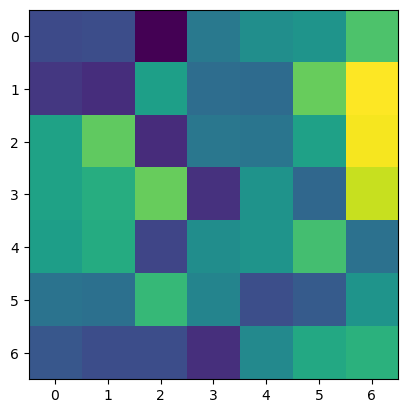

In [ ]:
''' visulaize latent space '''
cae.eval()
with torch.no_grad():
    z = X_ts
    for layer in cae.encoder:
        z = layer(z)
    z = z.squeeze().cpu().detach().numpy()   # latent space(z)

plt.imshow(z[0][0])